In [24]:
import pommerman
from pommerman import agents
from pommerman.constants import BOARD_SIZE
import numpy as np
import time
import os
from keras.layers import Input, Dense, Flatten, Convolution2D, BatchNormalization, Activation, Add
from keras.models import Model
import keras.backend as K
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
model_path = './supervised_learning/model/go_3res_block/model.h4'

In [3]:
# make sure TF does not allocate all memory
# NB! this needs to be done also in subprocesses!
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

In [4]:
class Trainer(agents.BaseAgent):
    def __init__(self, actions, save_path, save_best_only=True, seed=0):
        super().__init__()
        K.clear_session()
        self.save_path = save_path
        self.actions = actions
        self.save_best_only = save_best_only
        
        # Create model
        self.model = self.create_model(actions)
        # Load model if exists
        if not os.path.isdir(os.path.dirname(save_path)):
            os.makedirs(os.path.dirname(save_path))            
        if os.path.isfile(self.save_path):
            try:
                print("Trying to load model")
                self.model.load_weights(self.save_path)
                print("Model was loaded successful")
            except:
                print("Model load failed")
        
    def get_res_block(self, input):
        # Res block 1        
        x = Convolution2D(256, 3, padding='same')(input)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Convolution2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Add()([input, x])
        x = Activation('relu')(x)
        return x
        
    def create_model(self, actions, input_shape=(11, 11, 18,)):
        inp = Input(input_shape)
        x = Convolution2D(256, 3, padding='same')(inp)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 3 residual blocks
        for i in range(3):
            x = self.get_res_block(x)
        
        # Output block
        # Should be 2 filters
        x = Convolution2D(2, 1, padding='same')(x)
        x = BatchNormalization()(x)   
        x = Activation('relu')(x)
        x = Flatten()(x)  
        
        probs  = Dense(actions, activation='softmax', name='actions')(x)
        reward = Dense(1, name='reward')(x)
        
        model = Model(inputs = inp, outputs=[probs, reward])
        model.compile(optimizer='adam', loss=['categorical_crossentropy', 'mae'], metrics=['accuracy'])
        return model
        
    def featurize(self, obs):
        shape = (BOARD_SIZE, BOARD_SIZE, 1)

        def get_matrix(board, key):
            res = board[key]
            return res.reshape(shape).astype(np.float32)

        def get_map(board, item):
            map = np.zeros(shape)
            map[board == item] = 1
            return map

        board = get_matrix(obs, 'board')

        path_map       = get_map(board, 0)          # Empty space
        rigid_map      = get_map(board, 1)          # Rigid = 1
        wood_map       = get_map(board, 2)          # Wood = 2
        bomb_map       = get_map(board, 3)          # Bomb = 3
        flames_map     = get_map(board, 4)          # Flames = 4
        fog_map        = get_map(board, 5)          # TODO: not used for first two stages Fog = 5
        extra_bomb_map = get_map(board, 6)          # ExtraBomb = 6
        incr_range_map = get_map(board, 7)          # IncrRange = 7
        kick_map       = get_map(board, 8)          # Kick = 8
        skull_map      = get_map(board, 9)          # Skull = 9

        position = obs["position"]
        my_position = np.zeros(shape)
        my_position[position[0], position[1], 0] = 1

        team_mates = get_map(board, obs["teammate"].value) # TODO during documentation it should be an array

        enemies = np.zeros(shape)
        for enemy in obs["enemies"]:
            enemies[board == enemy.value] = 1

        bomb_blast_strength = get_matrix(obs, 'bomb_blast_strength')
        bomb_life           = get_matrix(obs, 'bomb_life')

        ammo           = np.full((BOARD_SIZE, BOARD_SIZE, 1), obs["ammo"])
        blast_strength = np.full((BOARD_SIZE, BOARD_SIZE, 1), obs["blast_strength"])
        can_kick       = np.full((BOARD_SIZE, BOARD_SIZE, 1), int(obs["can_kick"]))

        obs = np.concatenate([my_position, enemies, team_mates, path_map, rigid_map, 
                              wood_map, bomb_map, flames_map, fog_map, extra_bomb_map,
                              incr_range_map, kick_map, skull_map, bomb_blast_strength,
                              bomb_life, ammo, blast_strength, can_kick], axis=2)
        return obs.astype(np.int16)
    
    def act(self, obs, action_space):
        feat = self.featurize(obs)
        probs = self.model.predict(feat[np.newaxis])
        action = np.argmax(probs[0])
        return action

In [5]:
def eval(env, num_episodes):
    rewards = []
    lengths = []
    start_time = time.time()
    # Run the episodes just like OpenAI Gym
    for i_episode in range(num_episodes):
        state = env.reset()
        done = False
        lens = [None] * 4
        t = 0
        while not done:
            #env.render()
            actions = env.act(state)
            state, reward, done, info = env.step(actions)
            for j in range(4):
                if lens[j] is None and reward[j] != 0:
                    lens[j] = t
            t += 1
        rewards.append(reward)
        lengths.append(lens)
        print('Episode {} finished'.format(i_episode))
    elapsed = time.time() - start_time
    return rewards, lengths, elapsed

In [6]:
num_episodes = 100

In [7]:
# Create a set of agents (exactly four)
agent_list = [
    Trainer(6, model_path),
    agents.SimpleAgent(),
    agents.SimpleAgent(),
    agents.SimpleAgent(),
]

# Make the "Free-For-All" environment using the agent list
env = pommerman.make('PommeFFACompetition-v0', agent_list)

rewards0, lengths0, elapsed0 = eval(env, num_episodes)

Trying to load model


[2018-06-15 14:34:50,006] Making new env: PommeFFACompetition-v0


Model was loaded successful
Episode 0 finished
Episode 1 finished
Episode 2 finished
Episode 3 finished
Episode 4 finished
Episode 5 finished
Episode 6 finished
Episode 7 finished
Episode 8 finished
Episode 9 finished
Episode 10 finished
Episode 11 finished
Episode 12 finished
Episode 13 finished
Episode 14 finished
Episode 15 finished
Episode 16 finished
Episode 17 finished
Episode 18 finished
Episode 19 finished
Episode 20 finished
Episode 21 finished
Episode 22 finished
Episode 23 finished
Episode 24 finished
Episode 25 finished
Episode 26 finished
Episode 27 finished
Episode 28 finished
Episode 29 finished
Episode 30 finished
Episode 31 finished
Episode 32 finished
Episode 33 finished
Episode 34 finished
Episode 35 finished
Episode 36 finished
Episode 37 finished
Episode 38 finished
Episode 39 finished
Episode 40 finished
Episode 41 finished
Episode 42 finished
Episode 43 finished
Episode 44 finished
Episode 45 finished
Episode 46 finished
Episode 47 finished
Episode 48 finished
Ep

In [10]:
#### Create a set of agents (exactly four)
agent_list = [
    agents.SimpleAgent(),
    Trainer(6, model_path),
    agents.SimpleAgent(),
    agents.SimpleAgent(),
]

# Make the "Free-For-All" environment using the agent list
env = pommerman.make('PommeFFACompetition-v0', agent_list)

rewards1, lengths1, elapsed1 = eval(env, num_episodes)

Trying to load model


[2018-06-15 14:56:02,487] Making new env: PommeFFACompetition-v0


Model was loaded successful
Episode 0 finished
Episode 1 finished
Episode 2 finished
Episode 3 finished
Episode 4 finished
Episode 5 finished
Episode 6 finished
Episode 7 finished
Episode 8 finished
Episode 9 finished
Episode 10 finished
Episode 11 finished
Episode 12 finished
Episode 13 finished
Episode 14 finished
Episode 15 finished
Episode 16 finished
Episode 17 finished
Episode 18 finished
Episode 19 finished
Episode 20 finished
Episode 21 finished
Episode 22 finished
Episode 23 finished
Episode 24 finished
Episode 25 finished
Episode 26 finished
Episode 27 finished
Episode 28 finished
Episode 29 finished
Episode 30 finished
Episode 31 finished
Episode 32 finished
Episode 33 finished
Episode 34 finished
Episode 35 finished
Episode 36 finished
Episode 37 finished
Episode 38 finished
Episode 39 finished
Episode 40 finished
Episode 41 finished
Episode 42 finished
Episode 43 finished
Episode 44 finished
Episode 45 finished
Episode 46 finished
Episode 47 finished
Episode 48 finished
Ep

In [11]:
# Create a set of agents (exactly four)
agent_list = [
    agents.SimpleAgent(),
    agents.SimpleAgent(),
    Trainer(6, model_path),
    agents.SimpleAgent(),
]

# Make the "Free-For-All" environment using the agent list
env = pommerman.make('PommeFFACompetition-v0', agent_list)

rewards2, lengths2, elapsed2 = eval(env, num_episodes)

Trying to load model


[2018-06-15 15:12:23,511] Making new env: PommeFFACompetition-v0


Model was loaded successful
Episode 0 finished
Episode 1 finished
Episode 2 finished
Episode 3 finished
Episode 4 finished
Episode 5 finished
Episode 6 finished
Episode 7 finished
Episode 8 finished
Episode 9 finished
Episode 10 finished
Episode 11 finished
Episode 12 finished
Episode 13 finished
Episode 14 finished
Episode 15 finished
Episode 16 finished
Episode 17 finished
Episode 18 finished
Episode 19 finished
Episode 20 finished
Episode 21 finished
Episode 22 finished
Episode 23 finished
Episode 24 finished
Episode 25 finished
Episode 26 finished
Episode 27 finished
Episode 28 finished
Episode 29 finished
Episode 30 finished
Episode 31 finished
Episode 32 finished
Episode 33 finished
Episode 34 finished
Episode 35 finished
Episode 36 finished
Episode 37 finished
Episode 38 finished
Episode 39 finished
Episode 40 finished
Episode 41 finished
Episode 42 finished
Episode 43 finished
Episode 44 finished
Episode 45 finished
Episode 46 finished
Episode 47 finished
Episode 48 finished
Ep

In [12]:
# Create a set of agents (exactly four)
agent_list = [
    agents.SimpleAgent(),
    agents.SimpleAgent(),
    agents.SimpleAgent(),
    Trainer(6, model_path),
]

# Make the "Free-For-All" environment using the agent list
env = pommerman.make('PommeFFACompetition-v0', agent_list)

rewards3, lengths3, elapsed3 = eval(env, num_episodes)

Trying to load model


[2018-06-15 15:31:18,084] Making new env: PommeFFACompetition-v0


Model was loaded successful
Episode 0 finished
Episode 1 finished
Episode 2 finished
Episode 3 finished
Episode 4 finished
Episode 5 finished
Episode 6 finished
Episode 7 finished
Episode 8 finished
Episode 9 finished
Episode 10 finished
Episode 11 finished
Episode 12 finished
Episode 13 finished
Episode 14 finished
Episode 15 finished
Episode 16 finished
Episode 17 finished
Episode 18 finished
Episode 19 finished
Episode 20 finished
Episode 21 finished
Episode 22 finished
Episode 23 finished
Episode 24 finished
Episode 25 finished
Episode 26 finished
Episode 27 finished
Episode 28 finished
Episode 29 finished
Episode 30 finished
Episode 31 finished
Episode 32 finished
Episode 33 finished
Episode 34 finished
Episode 35 finished
Episode 36 finished
Episode 37 finished
Episode 38 finished
Episode 39 finished
Episode 40 finished
Episode 41 finished
Episode 42 finished
Episode 43 finished
Episode 44 finished
Episode 45 finished
Episode 46 finished
Episode 47 finished
Episode 48 finished
Ep

In [13]:
rewards = [(r0[0], r1[1], r2[2], r3[3]) for r0, r1, r2, r3 in zip(rewards0, rewards1, rewards2, rewards3)]

In [14]:
lengths = [(l0[0], l1[1], l2[2], l3[3]) for l0, l1, l2, l3 in zip(lengths0, lengths1, lengths2, lengths3)]

In [15]:
np.mean(rewards, axis=0), np.std(rewards, axis=0)

(array([-0.56, -0.58, -0.56, -0.48]),
 array([0.82849261, 0.81461647, 0.82849261, 0.87726849]))

In [16]:
np.mean(lengths, axis=0), np.std(lengths, axis=0)

(array([349.94, 256.33, 353.82, 280.97]),
 array([283.20451338, 238.45435853, 280.99104541, 251.10577273]))

In [17]:
np.mean(rewards), np.std(rewards)

(-0.545, 0.8384360440725338)

In [18]:
np.mean(lengths), np.std(lengths)

(310.265, 267.5414356225966)

In [19]:
elapsed = elapsed0 + elapsed1 + elapsed2 + elapsed3
total_timesteps = np.sum(np.max(np.concatenate([lengths0, lengths1, lengths2, lengths3], axis=0), axis=1))
elapsed, total_timesteps, elapsed / total_timesteps

(4248.225102901459, 169108, 0.025121372749375894)

In [20]:
np.savez_compressed("./eval_students/eval_students_%d.npz" % num_episodes, rewards=rewards, lengths=lengths, elapsed=elapsed, total_timesteps=total_timesteps,
                   rewards0=rewards0, rewards1=rewards1, rewards2=rewards2, rewards3=rewards3,
                   lengths0=lengths0, lengths1=lengths1, lengths2=lengths2, lengths3=lengths3,
                   elapsed0=elapsed0, elapsed1=elapsed1, elapsed2=elapsed2, elapsed3=elapsed3)

In [21]:
np.mean(rewards0, axis=0), np.std(rewards0, axis=0)

(array([-0.56, -0.78, -0.6 , -0.78]),
 array([0.82849261, 0.62577951, 0.8       , 0.62577951]))

In [22]:
np.mean(lengths0, axis=0), np.std(lengths0, axis=0)

(array([349.94, 231.33, 315.25, 243.95]),
 array([283.20451338, 239.89893935, 261.90129343, 254.97538607]))

In [23]:
elapsed = elapsed0
total_timesteps = np.sum(np.max(lengths0, axis=1))
elapsed, total_timesteps, elapsed / total_timesteps

(1116.254555940628, 44324, 0.025183976083851367)

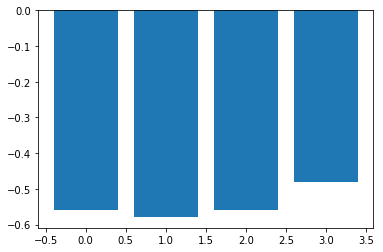

In [27]:
plt.bar([0,1,2,3], np.mean(rewards, axis=0))
plt.show()

In [28]:
np.mean(rewards)

-0.545